<a href="https://colab.research.google.com/github/fjavier141/proyecto-final-magister-ds/blob/main/notebooks/eda_diego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA - Proyecto : Potencial de crecimiento utilizando algoritmos de machine learning

In [1]:
pip install sqlalchemy psycopg2-binary pandas matplotlib seaborn python-dotenv python-decouple


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.8 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached python_dotenv-1.1.1-py3-none-any

In [15]:
### Importe de dependencias

import os
from dotenv import load_dotenv
from decouple import config
import pandas as pd
import numpy as np
from pathlib import Path
from sqlalchemy import create_engine, text

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
## Conexión SQL

user = 'diego'
contraseña = 'diego_2025%_mds'
base_datos = 'postgres_mag_ds'
host = '100.118.146.111'
puerto = ('53691','5432')
engine = create_engine(f'postgresql://{user}:{contraseña}@{host}:{puerto[0]}/{base_datos}')

try:
    with engine.connect() as conn:
        version = conn.execute(text("SELECT version();"))
        print("Conectado a:", list(version)[0][0])
except Exception as e:
    print("Error al conectar:", e)


Conectado a: PostgreSQL 15.13 (Debian 15.13-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


In [3]:
## Funciones Generales:

def conn_to_db(query):
    """Función para conectar a la base de datos y ejecutar una consulta SQL.
    Args:
        query (str): Consulta SQL a ejecutar.
    Returns:
        pd.DataFrame: Resultado de la consulta en un DataFrame de pandas.
    """
    with engine.connect() as conn:
        result = conn.execute(text(query))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

## Parte 1: Revisión General del dataset

### 1.1 Composición tablas proyecto

In [4]:
### Revisión General del Set de datos 
query_1 = """
SELECT
    t.relname AS Tabla,
    t.n_live_tup AS N_filas,
    COUNT(c.column_name) AS N_columnas
FROM pg_stat_user_tables t
LEFT JOIN information_schema.columns c
       ON c.table_schema = t.schemaname
      AND c.table_name   = t.relname
WHERE t.schemaname = 'stg'
GROUP BY t.schemaname, t.relname, t.relid, t.n_live_tup
ORDER BY pg_total_relation_size(t.relid) DESC;"""

df_sizes = conn_to_db(query_1)
df_sizes

,tabla,n_filas,n_columnas
0,venta_historica,93210352,8
1,base_clientes,727519,8
2,info_distritos,2767,8
3,datos_macro,85,9
4,info_segmentos,28,5


In [5]:
### Tipos de datos por tabla:
query_2 = """
SELECT table_name as Tabla,
       count(1) AS N_Columnas,
       count(1) FILTER (WHERE data_type ~* 'char|text') AS Columnas_Categoricas,
       count(1) FILTER (WHERE data_type ~* 'int|numeric|double|real|decimal') AS Columnas_Numericas,
       count(1) FILTER (WHERE data_type ~* 'date|time|timestamp') AS Columnas_Datetime,
       count(1) FILTER (WHERE data_type ~* 'bool') AS N_Columnas_Boleanas
FROM information_schema.columns
WHERE table_schema='stg'
GROUP BY 1
ORDER BY 1
"""
df_types = conn_to_db(query_2)
df_types

,tabla,n_columnas,columnas_categoricas,columnas_numericas,columnas_datetime,n_columnas_boleanas
0,base_clientes,8,3,3,2,0
1,datos_macro,9,0,7,2,0
2,info_distritos,8,0,6,2,0
3,info_segmentos,5,3,0,2,0
4,venta_historica,8,1,5,2,0


### 1.2 Revisión Tabla Venta_historica

In [6]:
query_3 = """
SELECT
  a.attname AS column_name,
  format_type(a.atttypid, a.atttypmod) AS data_type,
  c.reltuples::bigint AS approx_rows,
  (coalesce(s.null_frac,0) * c.reltuples)::bigint AS approx_n_nulos,
  round( (coalesce(s.null_frac,0) * 100)::numeric, 2 ) AS pct_null_est
FROM pg_attribute a
JOIN pg_class c
  ON c.oid = 'stg.venta_historica'::regclass
LEFT JOIN pg_stats s
  ON s.schemaname = 'stg'
 AND s.tablename  = 'venta_historica'
 AND s.attname    = a.attname
WHERE a.attrelid = 'stg.venta_historica'::regclass
  AND a.attnum > 0
  AND NOT a.attisdropped
ORDER BY a.attnum;
"""

df_3 = conn_to_db(query_3)
df_3

,column_name,data_type,approx_rows,approx_n_nulos,pct_null_est
0,id_categoria,integer,91683032,0,0.00
1,id_cliente,integer,91683032,0,0.00
2,id_periodo,integer,91683032,0,0.00
3,tipo_mix,character varying,91683032,0,0.00
4,id_sku_venta,integer,91683032,0,0.00
5,liq_um,double precision,91683032,0,0.00
6,created_at,timestamp without time zone,91683032,0,0.00
7,modified_at,timestamp without time zone,91683032,0,0.00


In [7]:
### Revisión liq_um negativo:

query_4 = """
SELECT *
FROM stg.venta_historica
WHERE liq_um < 0;
"""
df_4 = conn_to_db(query_4)

#### Print estadisticas:

print(f"Número de registros con liq_um negativo: {df_4.shape[0]}")
print(f"Porcentaje de registros con liq_um negativo: {df_4.shape[0] / df_sizes.query("tabla == 'venta_historica'")['n_filas'].values[0] * 100:.2f}%")
print(f'Suma total de liq_um negativo: {df_4["liq_um"].sum()}')

df_4.groupby('tipo_mix').agg(suma_liq_um = ('liq_um','sum'),
                            max_liq_um = ('liq_um','min'),
                            min_liq_um = ('liq_um','max'),
                            n_registros = ('liq_um','count')).reset_index()


Número de registros con liq_um negativo: 8941
Porcentaje de registros con liq_um negativo: 0.01%
Suma total de liq_um negativo: -4838.293134


,tipo_mix,suma_liq_um,max_liq_um,min_liq_um,n_registros
0,FUNCIONAL,-213.608144,-17.56800,-2.775558e-18,776
1,GASEOSAS,-827.436016,-31.58400,-2.775558e-18,2181
2,MASIVO,-1243.282544,-52.98216,-9.714451e-18,1536
3,MINERALES,-852.313280,-110.59200,-1.110223e-17,945
4,NECTAR,-150.243656,-19.15200,-5.551115e-18,563
5,PREMIUM,-1545.501174,-89.46000,-4.857226e-18,2859
6,TEA,-5.908320,-0.59520,-5.551115e-18,81


### 1.2.1 Visualización distribuciones

In [87]:
query_5 = """
select tipo_mix,liq_um
from stg.venta_historica;
"""
df_5 = conn_to_db(query_5)
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93157323 entries, 0 to 93157322
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   tipo_mix  object 
 1   liq_um    float64
dtypes: float64(1), object(1)
memory usage: 1.4+ GB


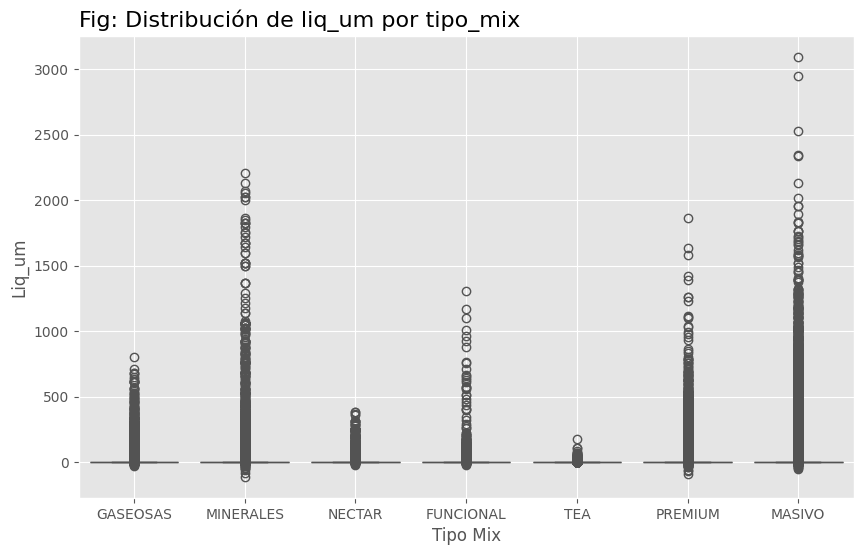

In [88]:
### Boxplot de liq_um por tipo_mix
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_5, x='tipo_mix', y='liq_um')
plt.title('Fig: Distribución de liq_um por tipo_mix', loc ='left', fontsize=16)
plt.xlabel('Tipo Mix')
plt.ylabel('Liq_um')
plt.grid(True)
plt.show();

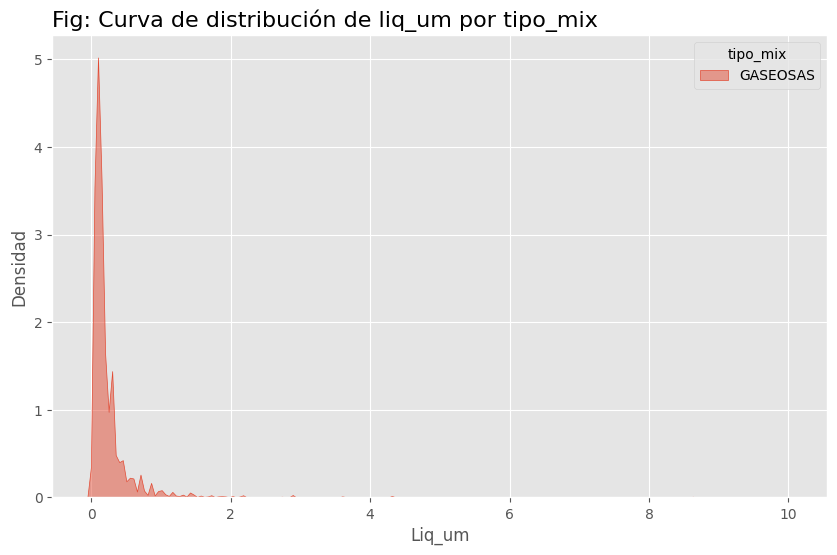

In [91]:
### Curva de distribución:

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_5.query("(tipo_mix == 'GASEOSAS') & (liq_um < 10) & (liq_um >0)"), x='liq_um', hue='tipo_mix', fill=True, common_norm=False, alpha=0.5)
plt.title('Fig: Curva de distribución de liq_um por tipo_mix', loc ='left', fontsize=16)
plt.xlabel('Liq_um')
plt.ylabel('Densidad')
plt.grid(True)
plt.show();

In [8]:
query_6 = """
SELECT  
    tipo_mix,
    MIN(liq_um) AS min_liq_um,
    MAX(liq_um) AS max_liq_um,
    ROUND(AVG(liq_um)::numeric, 2) AS avg_liq_um,
    ROUND(STDDEV(liq_um)::numeric, 2) AS stddev_liq_um,
    MODE() WITHIN GROUP (ORDER BY liq_um) AS mode_liq_um,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY liq_um) AS median_liq_um
FROM stg.venta_historica
WHERE liq_um > 0
GROUP BY tipo_mix
ORDER BY tipo_mix;
"""
df_6 = conn_to_db(query_6)
print("Estadísticas descriptivas de liq_um por tipo_mix (excluyendo valores negativos y cero):")
df_6

Estadísticas descriptivas de liq_um por tipo_mix (excluyendo valores negativos y cero):


,tipo_mix,min_liq_um,max_liq_um,avg_liq_um,stddev_liq_um,mode_liq_um,median_liq_um
0,FUNCIONAL,2.775558e-18,1310.30400,0.14,1.67,0.04800,0.04800
1,GASEOSAS,1.110223e-17,803.08800,0.33,1.88,0.09600,0.14400
2,MASIVO,9.714451e-18,3096.65328,1.38,10.08,0.05880,0.31584
3,MINERALES,1.110223e-17,2204.92800,0.35,4.57,0.07680,0.12000
4,NECTAR,1.110223e-17,380.16000,0.19,1.10,0.07200,0.07200
5,PREMIUM,9.714451e-18,1863.45600,0.59,4.10,0.05544,0.16380
6,TEA,5.551115e-18,180.00000,0.16,0.62,0.07200,0.07200


### 1.2.2 Visualización para entendimiento General del negocio

In [9]:
### Consulta agrupada por categoría de producto y año
query_5 = """
select id_periodo as periodo
    ,id_categoria as id_categoria
    ,tipo_mix as tipo_mix
    ,count(1) as cantidad_ventas
    ,sum(liq_um) as venta_hecto_litros
from stg.venta_historica
group by 1,2,3
order by 1;
"""
df_5 = conn_to_db(query_5)
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   periodo             328 non-null    int64  
 1   id_categoria        328 non-null    int64  
 2   tipo_mix            328 non-null    object 
 3   cantidad_ventas     328 non-null    int64  
 4   venta_hecto_litros  328 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 12.9+ KB


In [10]:
## Transformación de columna periodo a datetime
df_5['periodo'] = pd.to_datetime(df_5['periodo'], format='%Y%m')
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   periodo             328 non-null    datetime64[ns]
 1   id_categoria        328 non-null    int64         
 2   tipo_mix            328 non-null    object        
 3   cantidad_ventas     328 non-null    int64         
 4   venta_hecto_litros  328 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 12.9+ KB


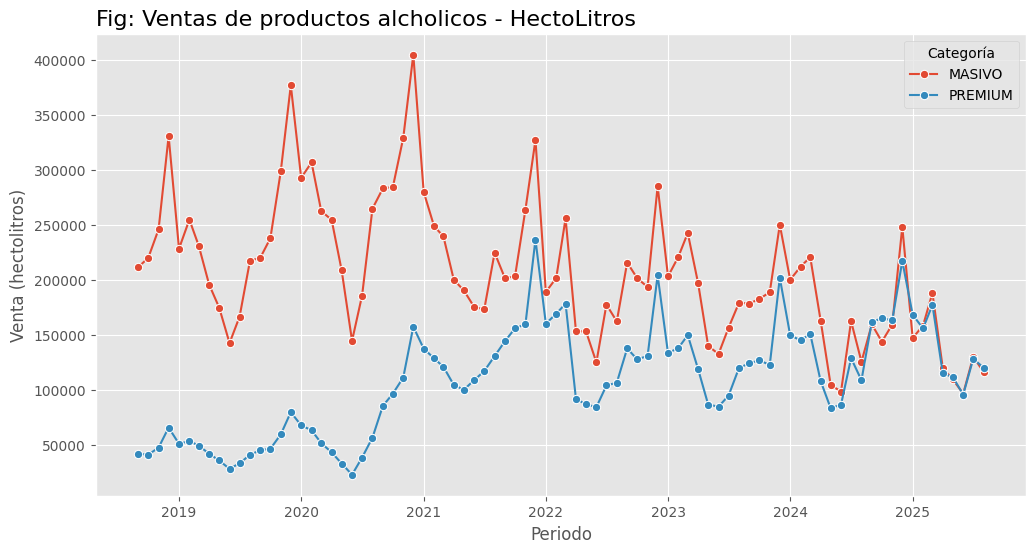

In [11]:
### Visualización de ventas por categoría y año
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_5.query("id_categoria == 1"), x='periodo', y='venta_hecto_litros', hue='tipo_mix', marker='o', legend='full')
plt.title('Fig: Ventas de productos alcholicos - HectoLitros', loc ='left', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Venta (hectolitros)')
plt.legend(title='Categoría')
plt.grid(True)
plt.show();

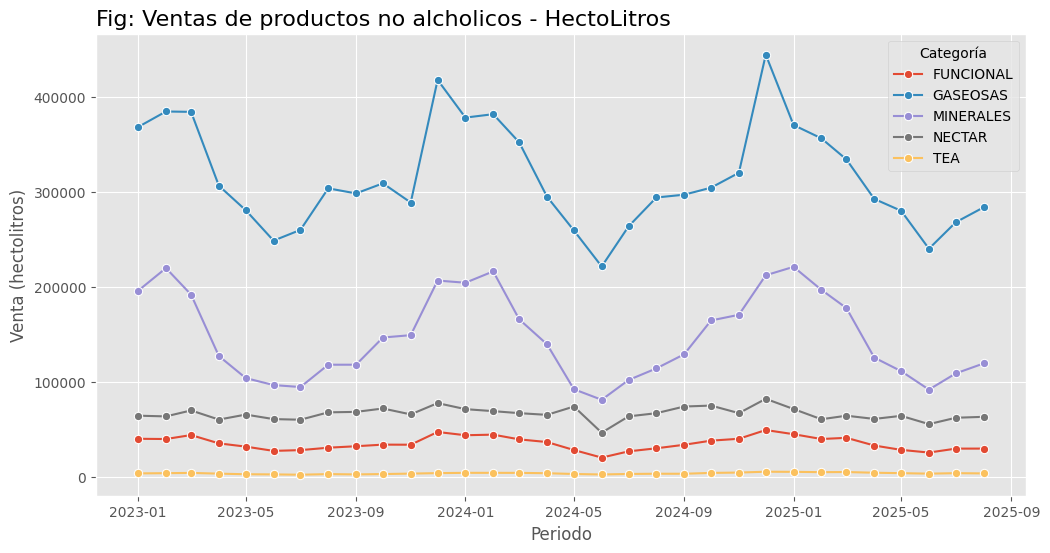

In [12]:
### Visualización de ventas por categoría y año
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_5.query("id_categoria == 3"), x='periodo', y='venta_hecto_litros', hue='tipo_mix', marker='o', legend='full')
plt.title('Fig: Ventas de productos no alcholicos - HectoLitros', loc ='left', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Venta (hectolitros)')
plt.legend(title='Categoría')
plt.grid(True)
plt.show();

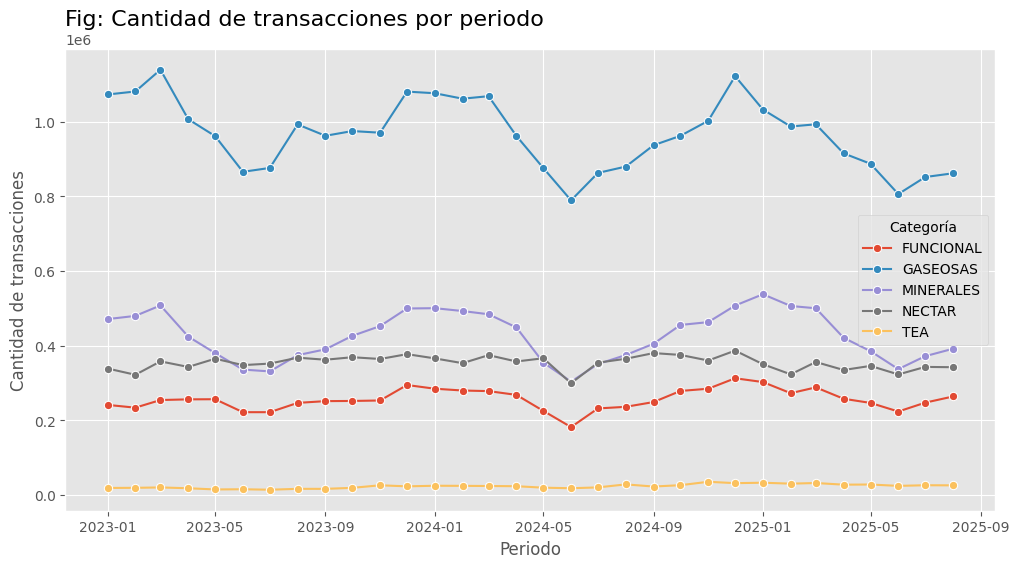

In [13]:
### Visualización de ventas por categoría y año
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_5.query("id_categoria == 3"), x='periodo', y='cantidad_ventas', hue='tipo_mix', marker='o', legend='full')
plt.title('Fig: Cantidad de transacciones por periodo', loc ='left', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Cantidad de transacciones')
plt.legend(title='Categoría')
plt.grid(True)
plt.show();

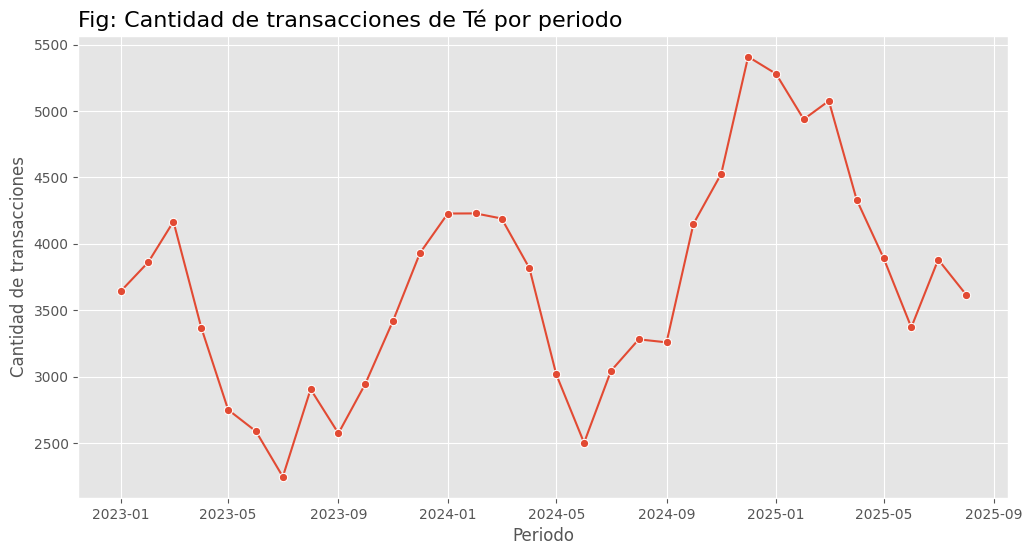

In [24]:
### Solo Te:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_5.query("(id_categoria == 3) & (tipo_mix == 'TEA')"), x='periodo', y='venta_hecto_litros', marker='o', legend='full')
plt.title('Fig: Cantidad de transacciones de Té por periodo', loc ='left', fontsize=16)
plt.xlabel('Periodo')
plt.ylabel('Cantidad de transacciones')
plt.grid(True)
plt.show(); 